Here, we want to know the model with the best explanatory power, compared to the rest.

## Requirements

```bash

mamba create -n acnets_bambi
mamba activate acnets_bambi
mamba install python ipykernel
pip install watermark bambi xarray netcdf4 seaborn
# pip install bokeh
```

In [3]:
import bambi
import arviz as az
import xarray as xr
import re
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
results = xr.open_dataset('models/connectivities_classifier-SVML1_measure-accuracy_top-6_cv-100x4fold.nc').load()

split_score_cols = [c for c in list(results.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = results[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)
scores['label'] = scores['label'].apply(lambda x: x.replace('partial correlation', 'partial_correlation'))

scores[['atlas','kind']] = scores['label'].apply(lambda x: x.split(' ')).apply(pd.Series)
scores = scores[['atlas', 'kind', 'test_score']]

In [5]:
model = bambi.Model('test_score ~ 0 + atlas * kind', scores)
fitted = model.fit(tune=100, draws=200, init='adapt_diag')

az.summary(fitted).sort_values('mean', ascending=False)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atlas, kind, atlas:kind, test_score_sigma]


Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.9098, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9038, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9032, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
atlas[dosenbach2010],4.618,0.127,4.399,4.868,0.006,0.004,485.0,401.0,1.00
atlas[gordon2014_2mm],4.182,0.123,3.934,4.401,0.005,0.003,638.0,541.0,1.00
atlas[difumo_64_2mm],3.909,0.128,3.679,4.142,0.008,0.006,239.0,289.0,1.01
test_score_sigma,1.244,0.022,1.202,1.287,0.001,0.001,876.0,611.0,1.00
"atlas:kind[dosenbach2010, partial_correlation]",1.012,0.250,0.548,1.493,0.014,0.010,322.0,382.0,1.01
"atlas:kind[gordon2014_2mm, tangent]",0.888,0.247,0.456,1.399,0.013,0.009,333.0,263.0,1.01
"atlas:kind[dosenbach2010, tangent]",0.843,0.251,0.354,1.292,0.013,0.009,389.0,356.0,1.00
"atlas:kind[gordon2014_2mm, covariance]",0.598,0.241,0.145,1.001,0.013,0.009,358.0,435.0,1.00
"atlas:kind[gordon2014_2mm, partial_correlation]",0.557,0.250,0.105,1.049,0.013,0.009,356.0,407.0,1.00
kind[precision],0.555,0.177,0.248,0.921,0.010,0.007,311.0,444.0,1.01


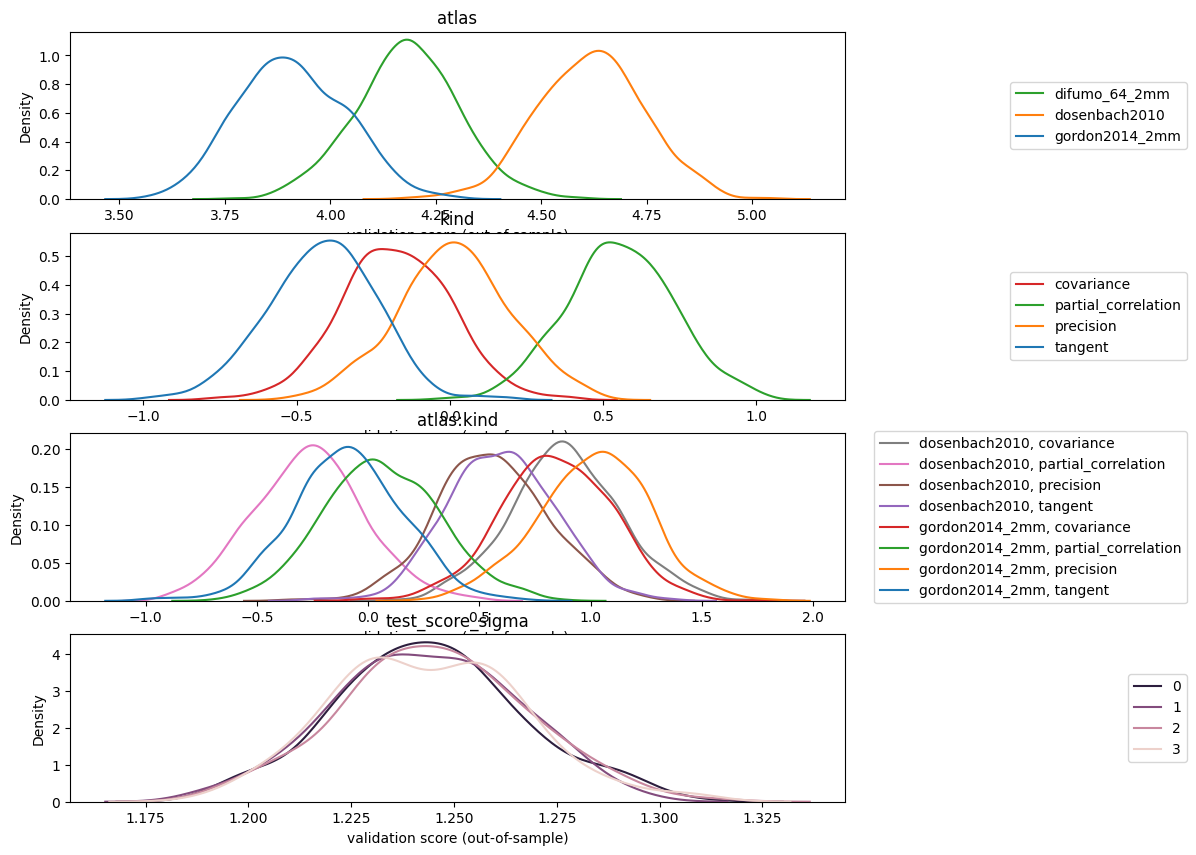

In [53]:
fitted['posterior']['atlas']

import seaborn as sns

fig, axes = plt.subplots(4, 1, figsize=(10, 10))

for i, var_name in enumerate(fitted['posterior'].data_vars):
    ax = axes.flatten()[i]
    plot_data = fitted['posterior'][var_name].to_dataframe().reset_index()
    hue_dim = 0 if 'test_score_sigma' in var_name else 2
    g = sns.kdeplot(data=plot_data,
                    x=var_name,
                    hue=fitted['posterior'][var_name].dims[hue_dim],
                    # height=2, aspect=2,
                    ax=ax)
    g.set(xlabel='validation score (out-of-sample)')
    g.set(title=var_name)
    ax.legend([t.get_text() for t in g.legend_.get_texts()],
              loc='center right', bbox_to_anchor=(1.45, 0.5), ncol=1)
plt.show()


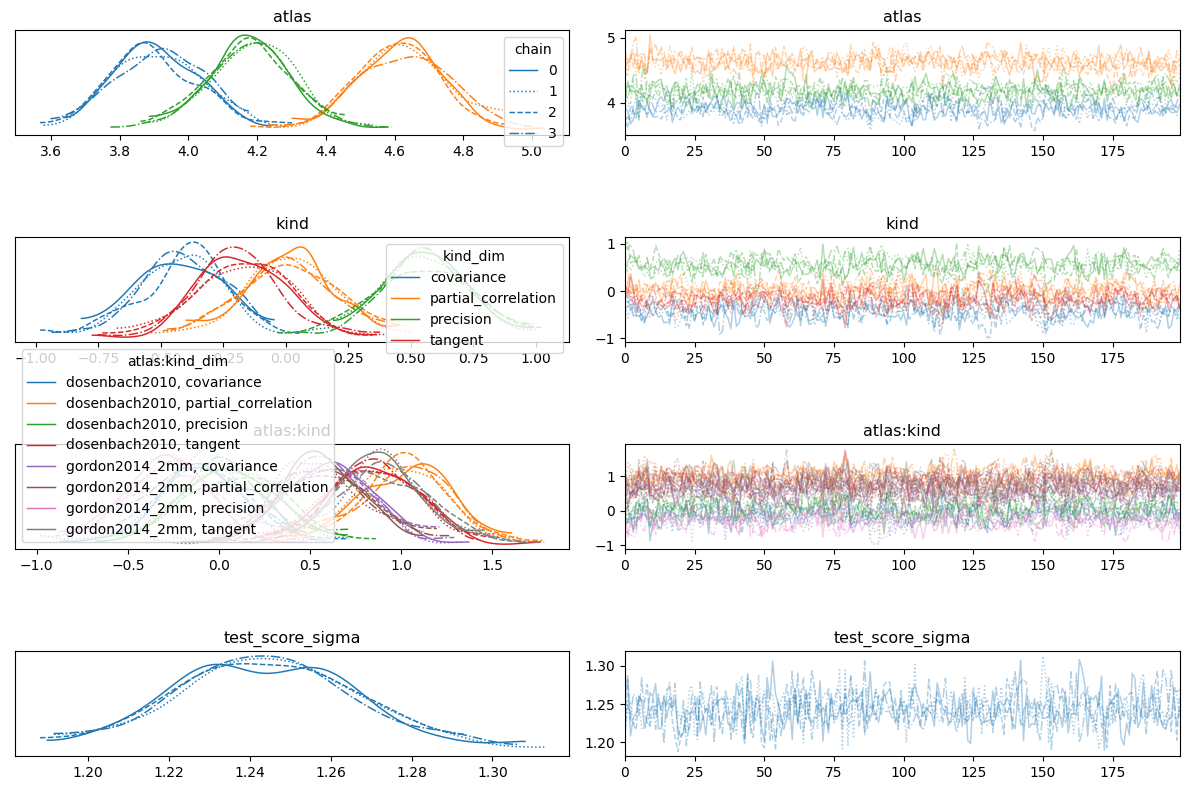

In [10]:
az.plot_trace(fitted, legend=True)

plt.tight_layout()
plt.show()

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jul 18 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:09:13) [Clang 13.0.1 ]
seaborn   : 0.11.2
pandas    : 1.4.3
re        : 2.2.1
matplotlib: 3.5.2
xarray    : 2022.3.0
bambi     : 0.9.0
arviz     : 0.12.1

Watermark: 2.3.1

